## **Imports and Dataset Preparation**

In [3]:
# Libraries for Image Processing and Modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import kagglehub
import cv2
import os
from glob import glob
from PIL import Image
from google.colab import files
import io
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Setting Seed
np.random.seed(101)
tf.random.set_seed(101)


In [4]:
dataset_path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
print(f"Dataset Path: {dataset_path}")


Dataset Path: /kaggle/input/breast-ultrasound-images-dataset


## **U-Net Multitask Model Definition**

In [5]:
def convolution_block(input_layer, filters, dropout_rate=0.1):
    # Single convolution block with dropout
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_layer)
    conv = Dropout(dropout_rate)(conv)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

def encoder_layers(inputs, filter_list):
    # Encoding path
    skip_connections = []
    x = inputs

    for filters in filter_list:
        conv = convolution_block(x, filters)
        skip_connections.append(conv)  # Save for skip connection
        x = MaxPooling2D((2, 2))(conv)

    return x, skip_connections

def decoder_layers(bottleneck, skip_connections, filter_list):
    # Decoding path
    x = bottleneck

    for i, filters in enumerate(reversed(filter_list)):
        skip = skip_connections[-(i+1)]
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = convolution_block(x, filters)

    return x

def segmentation_branch(decoder_output):
    # Segmentation output layer
    return Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(decoder_output)

def classification_branch(bottleneck_output, num_classes):
    # Classification output layer
    gap = GlobalAveragePooling2D()(bottleneck_output)
    dense = Dense(128, activation='relu')(gap)
    drop = Dropout(0.3)(dense)
    return Dense(num_classes, activation='softmax', name='classification')(drop)

def create_multitask_unet(input_shape=(128, 128, 3), num_classes=3):
    # Input Layer
    input_tensor = Input(input_shape)

    # Encoder (Downsampling)
    encoder_filters = [64, 128, 256, 512]
    bottleneck, skips = encoder_layers(input_tensor, encoder_filters)

    # Bottleneck (Middle Block)
    bottleneck = convolution_block(bottleneck, 1024)

    # Decoder (Upsampling)
    decoder_output = decoder_layers(bottleneck, skips, encoder_filters)

    # Multitask Outputs
    seg_output = segmentation_branch(decoder_output)
    cls_output = classification_branch(bottleneck, num_classes)

    # Model assembly
    multitask_model = Model(inputs=input_tensor, outputs=[seg_output, cls_output])

    return multitask_model


## **Data Preparation Function**

In [6]:
def prepare_balanced_dataset(base_path, image_dims=(128,128), max_samples_per_class=133):
    class_map = {'normal': 0, 'benign': 1, 'malignant': 2}
    img_array, mask_array, label_array = [], [], []
    main_dir = os.path.join(base_path, "Dataset_BUSI_with_GT")

    for cls in class_map:
        # Get all image paths for the current class
        all_img_paths = glob(os.path.join(main_dir, cls, "*.png"))
        # Filter out mask files
        img_paths = [p for p in all_img_paths if "_mask" not in p]

        # Shuffle and limit the number of samples per class
        img_paths = shuffle(img_paths)[:max_samples_per_class]

        for img_path in img_paths:
            # Load the image
            img = cv2.imread(img_path)

            # Noise Reduction
            img = cv2.GaussianBlur(img, (5, 5), 0)

            # Morphological Processing
            kernel = np.ones((3, 3), np.uint8)
            img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

            # Mask Loading
            mask_path = img_path.replace(".png", "_mask.png")
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(mask_path) else np.zeros(img.shape[:2])

            # Resize and Normalize
            img = cv2.resize(img, image_dims) / 255.0
            mask = cv2.resize(mask, image_dims)
            mask = np.expand_dims((mask > 128).astype(np.float32), axis=-1)

            # Append to respective lists
            img_array.append(img)
            mask_array.append(mask)
            label_array.append(class_map[cls])

    # Shuffle the final dataset to avoid class ordering issues
    img_array, mask_array, label_array = shuffle(img_array, mask_array, label_array)

    return np.array(img_array), np.array(mask_array), tf.keras.utils.to_categorical(label_array, 3)


## **Dataset Loading & Splitting**

In [7]:
imgs, masks, labels = prepare_balanced_dataset(dataset_path)

X_train, X_test, y_train_mask, y_test_mask, y_train_label, y_test_label = train_test_split(imgs, masks, labels, test_size=0.2, stratify=labels, random_state=101)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_test.shape[0]}")

Train samples: 319, Validation samples: 80


## **Mask and Label Verification**

In [8]:
def verify_masks_and_labels(X_train, y_train_mask, y_train_label, X_test, y_test_mask, y_test_label):
    class_map = {0: 'normal', 1: 'benign', 2: 'malignant'}

    def check_valid_mask(mask, label):
        if label == 0 and np.count_nonzero(mask) > 0:
            return False  # Normal image should have an empty mask
        if label in [1, 2] and np.count_nonzero(mask) == 0:
            return False  # Benign and Malignant should have non-empty masks
        return True

    # Verify training set
    for i in range(len(X_train)):
        if not check_valid_mask(y_train_mask[i], np.argmax(y_train_label[i])):
            print(f"⚠️  Inconsistent Training Data: Image {i} (Label: {class_map[np.argmax(y_train_label[i])]}) has an invalid mask.")

    # Verify test set
    for j in range(len(X_test)):
        if not check_valid_mask(y_test_mask[j], np.argmax(y_test_label[j])):
            print(f"⚠️  Inconsistent Test Data: Image {j} (Label: {class_map[np.argmax(y_test_label[j])]}) has an invalid mask.")

    print("✅ Mask and Label Verification Completed.")

# Run verification
verify_masks_and_labels(X_train, y_train_mask, y_train_label, X_test, y_test_mask, y_test_label)


✅ Mask and Label Verification Completed.


## **Compile with Dice Loss for Segmentation**

In [9]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy


def compute_dice_loss(true_mask, predicted_mask, epsilon=1e-6):
    overlap = tf.reduce_sum(true_mask * predicted_mask)
    combined = tf.reduce_sum(true_mask) + tf.reduce_sum(predicted_mask)
    dice = (2 * overlap + epsilon) / (combined + epsilon)
    return 1 - dice

focal_loss = CategoricalCrossentropy(label_smoothing=0.1)
multi_task_model = create_multitask_unet(input_shape=X_train.shape[1:])

# Optimizer with Learning Rate Decay
optimizer = Adam(learning_rate=1e-4)

# Compile the model
multi_task_model.compile(
    optimizer=optimizer,
    loss={
        'segmentation': compute_dice_loss,
        'classification': focal_loss
    },
    loss_weights={
        'segmentation': 0.7,  # 70% weight for segmentation
        'classification': 0.3  # 30% weight for classification
    },
    metrics={
        'segmentation': [MeanIoU(num_classes=2), 'accuracy'],
        'classification': ['accuracy']
    }
)

# Add Callbacks for Better Training Stability
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

callbacks_list = [early_stopping, reduce_lr]

multi_task_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,163,332 (118.88 MB)

 Trainable params: 31,163,332 (118.88 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks & Training**

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import Callback

class DetailedTrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\n📅 **Epoch {epoch + 1} Summary**")
        print("🔹 Segmentation Metrics")
        print(f"   - Loss: {logs['segmentation_loss']:.4f} | Val Loss: {logs['val_segmentation_loss']:.4f}")
        print(f"   - Accuracy: {logs['segmentation_accuracy']:.4f} | Val Accuracy: {logs['val_segmentation_accuracy']:.4f}")
        print(f"   - Mean IoU: {logs['segmentation_mean_io_u']:.4f} | Val Mean IoU: {logs['val_segmentation_mean_io_u']:.4f}")

        print("\n🔹 Classification Metrics")
        print(f"   - Loss: {logs['classification_loss']:.4f} | Val Loss: {logs['val_classification_loss']:.4f}")
        print(f"   - Accuracy: {logs['classification_accuracy']:.4f} | Val Accuracy: {logs['val_classification_accuracy']:.4f}")

        print("\n🔹 Combined Metrics")
        print(f"   - Total Loss: {logs['loss']:.4f} | Val Total Loss: {logs['val_loss']:.4f}")
        print("-" * 60)


detailed_logger = DetailedTrainingLogger()


training_callbacks = [
    ModelCheckpoint("ultrasound_segmentation.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    detailed_logger
]

history_log = multi_task_model.fit(
    X_train, {'segmentation': y_train_mask, 'classification': y_train_label},
    validation_data=(X_test, {'segmentation': y_test_mask, 'classification': y_test_label}),
    epochs=100, batch_size=16, callbacks=training_callbacks, verbose=0
)



📅 **Epoch 1 Summary**
🔹 Segmentation Metrics
   - Loss: 0.8715 | Val Loss: 0.8784
   - Accuracy: 0.0889 | Val Accuracy: 0.1897
   - Mean IoU: 0.4626 | Val Mean IoU: 0.4648

🔹 Classification Metrics
   - Loss: 1.1005 | Val Loss: 1.0986
   - Accuracy: 0.3103 | Val Accuracy: 0.3250

🔹 Combined Metrics
   - Total Loss: 0.9402 | Val Total Loss: 0.9445
------------------------------------------------------------

📅 **Epoch 2 Summary**
🔹 Segmentation Metrics
   - Loss: 0.8698 | Val Loss: 0.8749
   - Accuracy: 0.3013 | Val Accuracy: 0.1932
   - Mean IoU: 0.4626 | Val Mean IoU: 0.4648

🔹 Classification Metrics
   - Loss: 1.0986 | Val Loss: 1.0986
   - Accuracy: 0.3041 | Val Accuracy: 0.3250

🔹 Combined Metrics
   - Total Loss: 0.9385 | Val Total Loss: 0.9420
------------------------------------------------------------

📅 **Epoch 3 Summary**
🔹 Segmentation Metrics
   - Loss: 0.8540 | Val Loss: 0.8223
   - Accuracy: 0.2180 | Val Accuracy: 0.5102
   - Mean IoU: 0.4626 | Val Mean IoU: 0.4648

🔹 Cl

**Training Visualization**

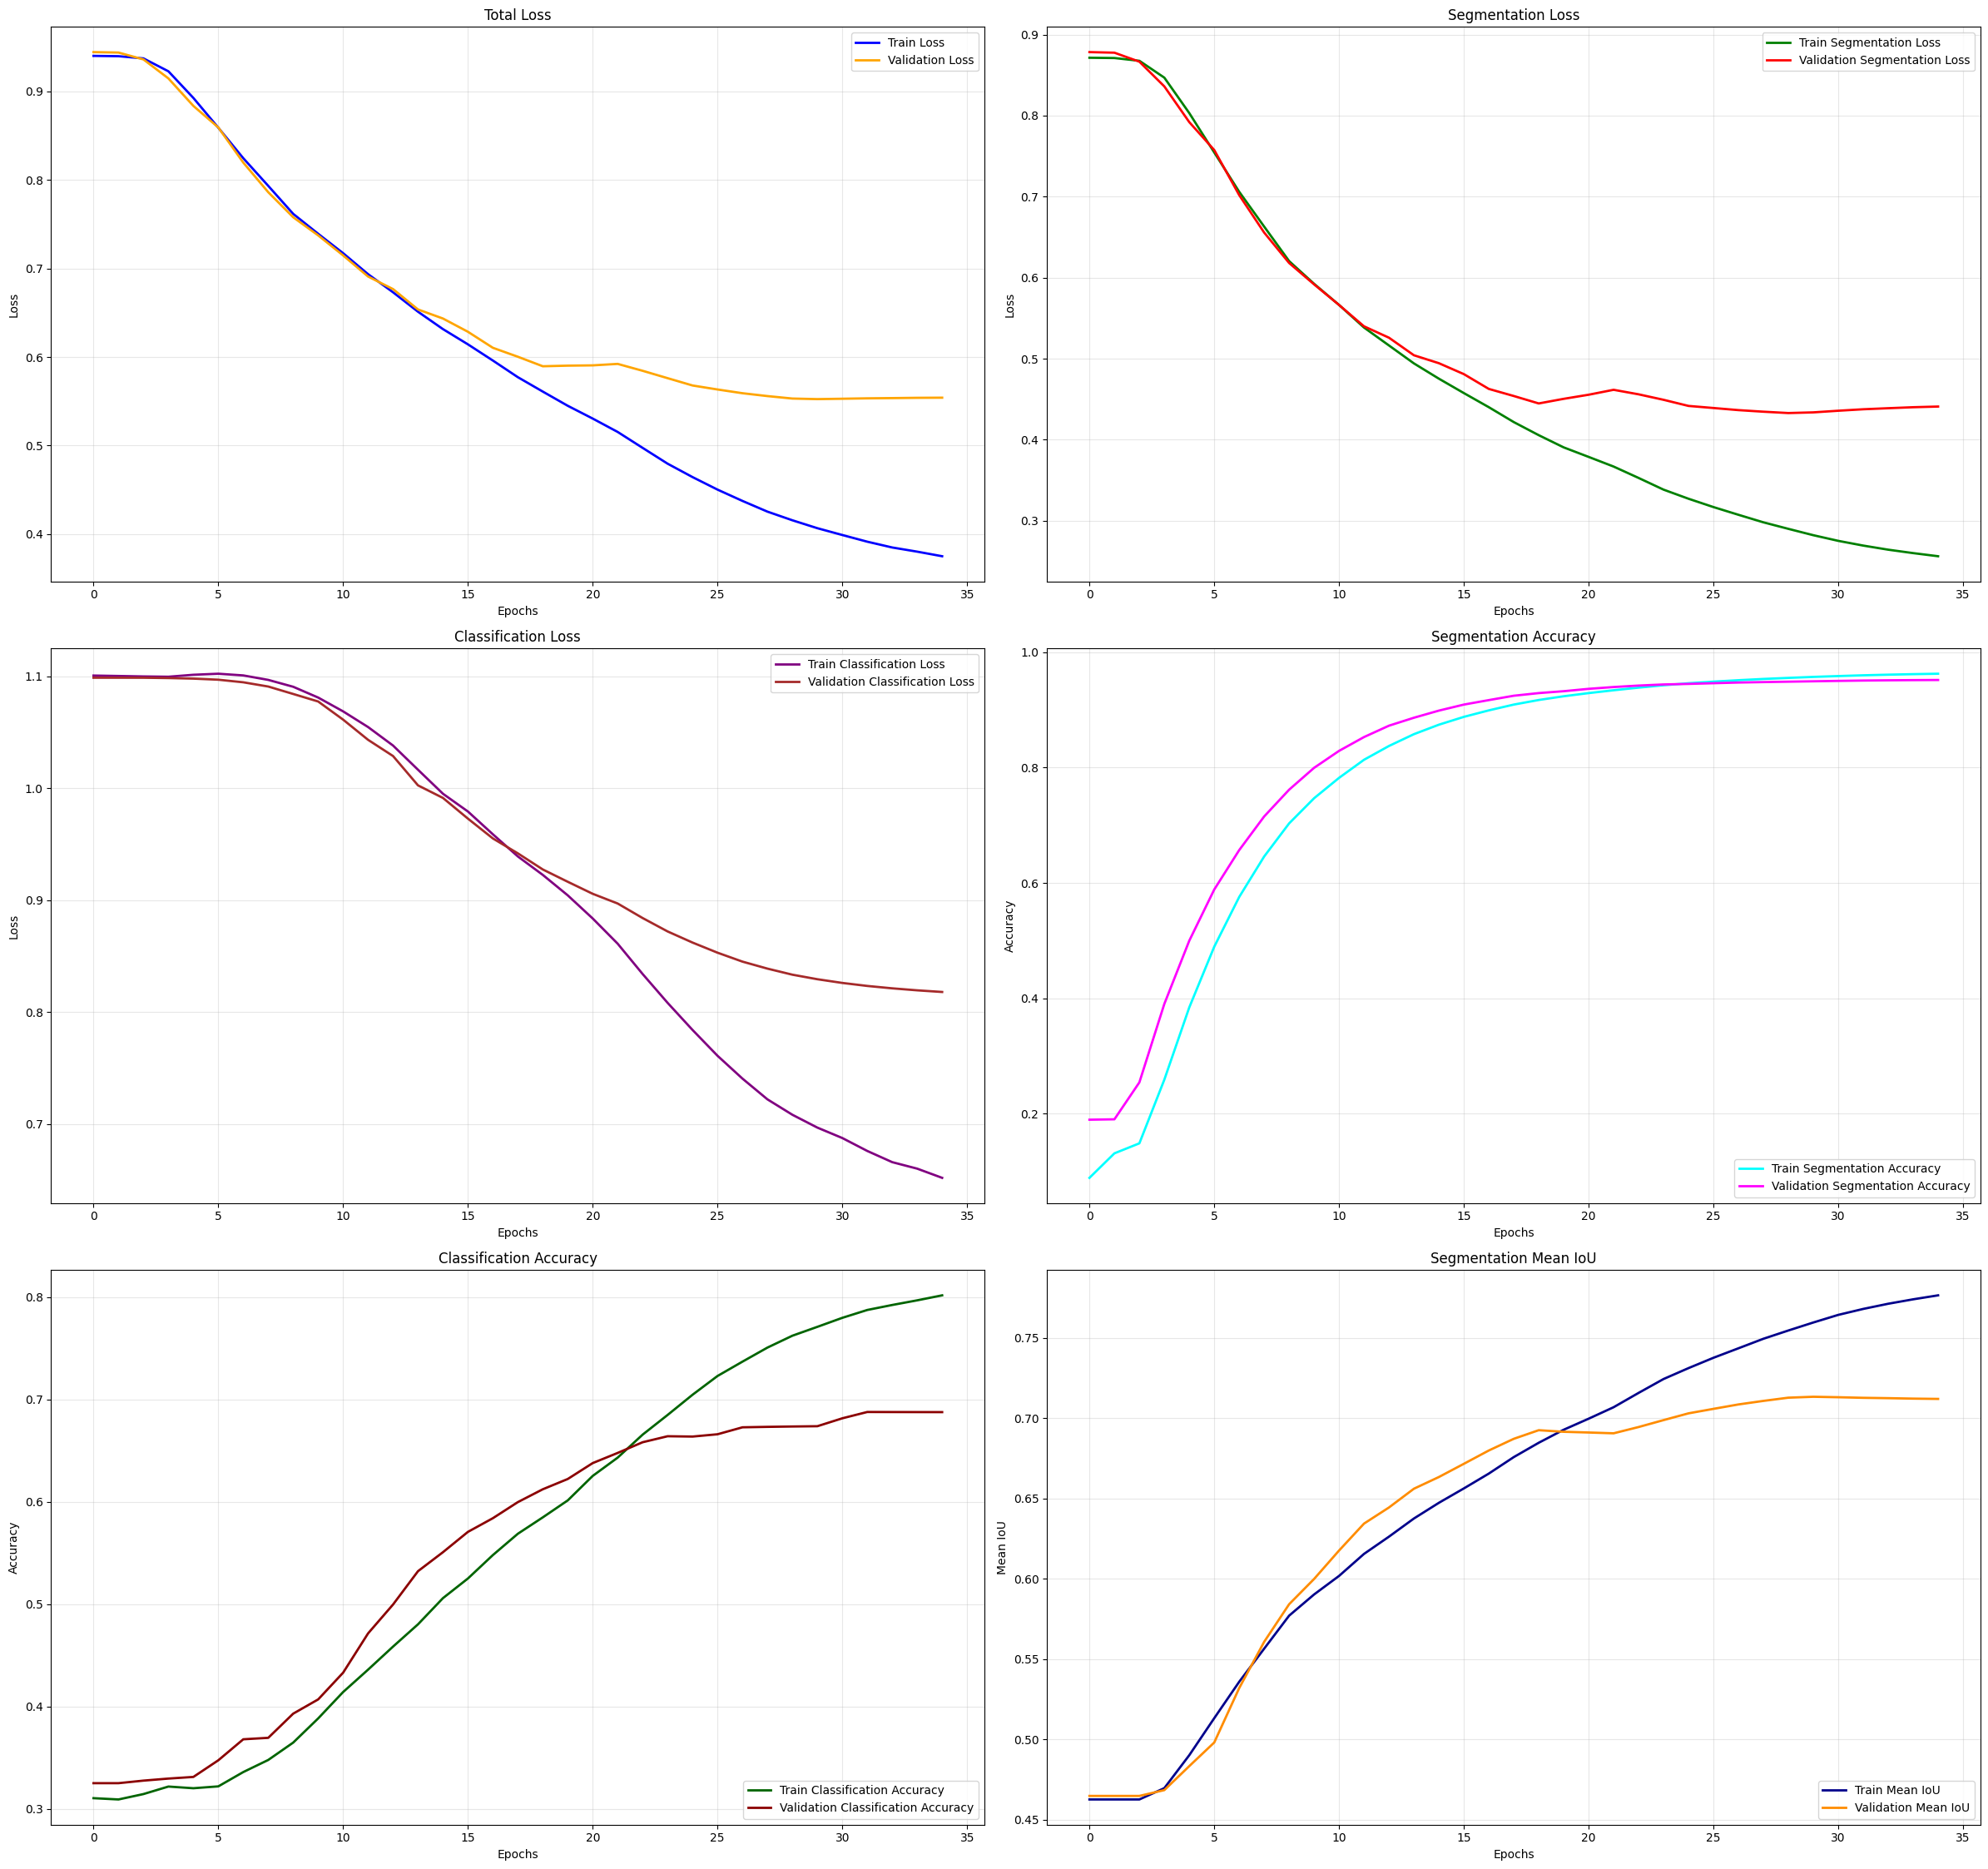

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert training history to a DataFrame for easier plotting
history_df = pd.DataFrame(history_log.history)

# Smoothing Function
def smooth_curve(data, factor=0.8):
    smoothed = []
    for point in data:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(24, 24))

# 1. Total Loss
axes[0, 0].plot(smooth_curve(history_df['loss']), label="Train Loss", color='blue', linewidth=2)
axes[0, 0].plot(smooth_curve(history_df['val_loss']), label="Validation Loss", color='orange', linewidth=2)
axes[0, 0].set_title("Total Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend(loc="upper right")
axes[0, 0].grid(True, alpha=0.3)

# 2. Segmentation Loss
axes[0, 1].plot(smooth_curve(history_df['segmentation_loss']), label="Train Segmentation Loss", color='green', linewidth=2)
axes[0, 1].plot(smooth_curve(history_df['val_segmentation_loss']), label="Validation Segmentation Loss", color='red', linewidth=2)
axes[0, 1].set_title("Segmentation Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend(loc="upper right")
axes[0, 1].grid(True, alpha=0.3)

# 3. Classification Loss
axes[1, 0].plot(smooth_curve(history_df['classification_loss']), label="Train Classification Loss", color='purple', linewidth=2)
axes[1, 0].plot(smooth_curve(history_df['val_classification_loss']), label="Validation Classification Loss", color='brown', linewidth=2)
axes[1, 0].set_title("Classification Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend(loc="upper right")
axes[1, 0].grid(True, alpha=0.3)

# 4. Segmentation Accuracy
axes[1, 1].plot(smooth_curve(history_df['segmentation_accuracy']), label="Train Segmentation Accuracy", color='cyan', linewidth=2)
axes[1, 1].plot(smooth_curve(history_df['val_segmentation_accuracy']), label="Validation Segmentation Accuracy", color='magenta', linewidth=2)
axes[1, 1].set_title("Segmentation Accuracy")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

# 5. Classification Accuracy
axes[2, 0].plot(smooth_curve(history_df['classification_accuracy']), label="Train Classification Accuracy", color='darkgreen', linewidth=2)
axes[2, 0].plot(smooth_curve(history_df['val_classification_accuracy']), label="Validation Classification Accuracy", color='darkred', linewidth=2)
axes[2, 0].set_title("Classification Accuracy")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Accuracy")
axes[2, 0].legend(loc="lower right")
axes[2, 0].grid(True, alpha=0.3)

# 6. Segmentation Mean IoU
axes[2, 1].plot(smooth_curve(history_df['segmentation_mean_io_u']), label="Train Mean IoU", color='darkblue', linewidth=2)
axes[2, 1].plot(smooth_curve(history_df['val_segmentation_mean_io_u']), label="Validation Mean IoU", color='darkorange', linewidth=2)
axes[2, 1].set_title("Segmentation Mean IoU")
axes[2, 1].set_xlabel("Epochs")
axes[2, 1].set_ylabel("Mean IoU")
axes[2, 1].legend(loc="lower right")
axes[2, 1].grid(True, alpha=0.3)

# Tight layout for better readability
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("clean_detailed_training_metrics.png", dpi=300)
plt.show()


**Predictions Visualizations**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_predictions_with_transparent_overlay(model, inputs, true_masks, true_labels, sample=5, overlay_alpha=0.4):
    # Randomly pick a few samples for visualization
    sample_indices = random.sample(range(len(inputs)), sample)
    preds_mask, preds_label = model.predict(inputs[sample_indices])

    # Class labels
    class_labels = ['Normal', 'Benign', 'Malignant']

    plt.figure(figsize=(20, sample * 5))

    for i, idx in enumerate(sample_indices):
        # Extract the original image, true mask, and predicted mask
        orig_image = inputs[idx]
        true_mask = true_masks[idx].squeeze()
        pred_mask = preds_mask[i].squeeze()
        true_class = class_labels[np.argmax(true_labels[idx])]
        pred_class = class_labels[np.argmax(preds_label[i])]

        # Create overlay images with lower opacity
        overlay = orig_image.copy()
        true_overlay = orig_image.copy()
        pred_overlay = orig_image.copy()

        # Apply red overlay for ground truth (lower opacity)
        true_overlay[true_mask > 0.5] = [0.8, 0.0, 0.0]  # Red
        overlay = overlay_alpha * true_overlay + (1 - overlay_alpha) * overlay

        # Apply green overlay for prediction (lower opacity)
        pred_overlay[pred_mask > 0.5] = [0.0, 0.8, 0.0]  # Green
        overlay = overlay_alpha * pred_overlay + (1 - overlay_alpha) * overlay

        # Plot Original Image
        plt.subplot(sample, 4, 4 * i + 1)
        plt.imshow(orig_image)
        plt.title(f"Original Image (True: {true_class})")
        plt.axis('off')

        # Plot Ground Truth Mask
        plt.subplot(sample, 4, 4 * i + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(sample, 4, 4 * i + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask (Pred: {pred_class})")
        plt.axis('off')

        # Plot Overlay with Lower Opacity
        plt.subplot(sample, 4, 4 * i + 4)
        plt.imshow(overlay)
        plt.title(f"Overlay (True: {true_class}, Pred: {pred_class})")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('transparent_overlay_predictions.png')
    plt.show()

# Run the enhanced visualization
visualize_predictions_with_transparent_overlay(multi_task_model, X_test, y_test_mask, y_test_label)


**Confusion Matrix & Performance Metrics**

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 407ms/step
🔹 Mean IoU (Segmentation): 0.7174
🔹 Dice Coefficient (Segmentation): 0.6565
🔹 Pixel Accuracy (Segmentation): 0.9488

🔸 Classification Report:
              precision    recall  f1-score   support

      Normal       0.69      0.69      0.69        26
      Benign       0.58      0.52      0.55        27
   Malignant       0.70      0.78      0.74        27

    accuracy                           0.66        80
   macro avg       0.66      0.66      0.66        80
weighted avg       0.66      0.66      0.66        80



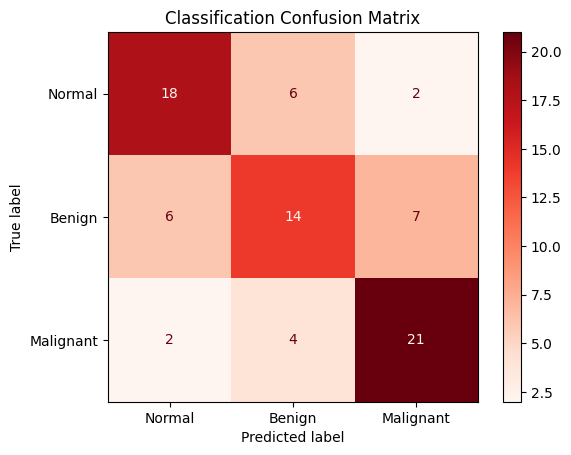

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Custom Dice Coefficient Function (Segmentation)
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon)
    return dice

# Pixel Accuracy Calculation
def pixel_accuracy(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    correct_pixels = tf.reduce_sum(tf.cast(y_true_f == y_pred_f, tf.float32))
    total_pixels = tf.size(y_true_f, out_type=tf.float32)
    return correct_pixels / total_pixels

# Evaluate Model on Test Data
segmentation_predictions, classification_predictions = multi_task_model.predict(X_test)

# Convert Predictions for Metrics Calculation
segmentation_preds_binary = (segmentation_predictions > 0.5).astype(np.float32)  # Convert to float32
classification_preds_labels = np.argmax(classification_predictions, axis=1)
y_test_labels = np.argmax(y_test_label, axis=1)

# Calculate MeanIoU, Dice Coefficient, and Pixel Accuracy
mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(y_test_mask.astype(np.float32), segmentation_preds_binary)
dice_score = dice_coefficient(y_test_mask, segmentation_preds_binary)
pixel_acc = pixel_accuracy(y_test_mask, segmentation_preds_binary)

print(f"🔹 Mean IoU (Segmentation): {mean_iou.result().numpy():.4f}")
print(f"🔹 Dice Coefficient (Segmentation): {dice_score.numpy():.4f}")
print(f"🔹 Pixel Accuracy (Segmentation): {pixel_acc.numpy():.4f}")

# Per-Class Analysis for Classification
print("\n🔸 Classification Report:")
print(classification_report(y_test_labels, classification_preds_labels, target_names=['Normal', 'Benign', 'Malignant']))

# Confusion Matrix for Better Visual Analysis
conf_matrix = confusion_matrix(y_test_labels, classification_preds_labels)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Normal', 'Benign', 'Malignant'])
disp.plot(cmap='Reds')
plt.title("Classification Confusion Matrix")
plt.show()


## **Testing Model**

In [16]:
# Set the desired input image size (same as the training size)
IMAGE_SIZE = (128, 128)

# Define colors for different classes
CLASS_COLORS = {
    0: (0, 255, 0),    # Green for Normal
    1: (255, 255, 0),  # Yellow for Benign
    2: (0, 0, 255)     # Red for Malignant
}

def predict_and_visualize(model, image_path, alpha=0.4):
    # Load and preprocess the image
    original_image = cv2.imread(image_path)
    original_size = original_image.shape[:2]  # Save the original image size for resizing later
    resized_image = cv2.resize(original_image, IMAGE_SIZE) / 255.0
    reshaped_image = np.expand_dims(resized_image, axis=0)

    # Run the model to get segmentation and classification predictions
    segmentation_pred, classification_pred = model.predict(reshaped_image)

    # Convert segmentation prediction to binary mask
    binary_mask = (segmentation_pred[0] > 0.5).astype(np.float32)

    # Resize the binary mask back to the original image size
    binary_mask_resized = cv2.resize(binary_mask, (original_size[1], original_size[0]))

    # Map classification prediction to label
    predicted_class = np.argmax(classification_pred[0])
    predicted_label = ["Normal", "Benign", "Malignant"][predicted_class]
    overlay_color = CLASS_COLORS[predicted_class]

    # Create a color overlay
    color_mask = np.zeros_like(original_image)
    color_mask[binary_mask_resized > 0.5] = overlay_color

    # Apply transparency (alpha blending)
    transparent_overlay = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

    # Visualization
    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask_resized, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(transparent_overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay (Predicted Class: {predicted_label})")
    plt.axis("off")

    plt.show()


test_image_path = input("Please provide the image path: ")

if test_image_path.lower() == 'exit':
    print("Exiting the program.")
    exit()
else:
  predict_and_visualize(multi_task_model, test_image_path)


Please provide the image path: exit
Exiting the program.
